# Importing libraries, loading and transforming data

In [1]:
# Install the 'evaluate' library with the specified version (4.28.1) quietly (-q).
!pip install -q evaluate transformers==4.28.1

# Upgrade the 'datasets' library to the latest version quietly (-q).
!pip install -U -q datasets

# Install the 'torchaudio' library with the specified version (0.12.0+cu113) from the provided CUDA version repository.
!pip install -q torchaudio==0.12.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

# Add the 'ffmpeg4' repository to the package manager's sources list (-y for yes).
!add-apt-repository -y ppa:savoury1/ffmpeg4 

# Install the 'ffmpeg' package quietly (-qq).
!apt-get -qq install -y ffmpeg

# Install the 'mlflow' library quietly (-q).
!pip install -q mlflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.12.0+cu113 which is incompatible.
Repository: 'deb https://ppa.launchpadcontent.net/savoury1/ffmpeg4/ubuntu/ jammy main'
Description:
FFmpeg 4.4.4 builds (& associated multimedia packages) for Xenial & newer.

*** Anyone interested in full builds of FFmpeg 4.4.x including all "bells and whistles" needs to have donated, after which access to the new private PPA can be requested. See my Launchpad page linked below for details. ***

*** Please always see https://launchpad.net/~savoury1 for general updates about this Launchpad site before contacting me or reporting any bugs! ***

*** Big thanks to all those who have donated to support this project, you are very directly helping to keep it alive! To all who have not donated: please do so if you can afford it, 

In [2]:
# Import necessary libraries
import pandas as pd  # Pandas for data manipulation
import gc  # Garbage collection module
import re  # Regular expressions for text processing
import numpy as np  # NumPy for numerical operations

# Suppress warnings
import warnings 
warnings.filterwarnings("ignore")

# Import tqdm for progress tracking
from tqdm import tqdm
tqdm.pandas()

# Import Path from pathlib for working with file paths
from pathlib import Path

# Import oversampling and undersampling methods from imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Import class_weight calculation function from scikit-learn
from sklearn.utils.class_weight import compute_class_weight

# Import matplotlib for data visualization
import matplotlib.pyplot as plt

# Import itertools for working with iterators
import itertools

# Import various metrics from scikit-learn
from sklearn.metrics import (
    accuracy_score,  # For calculating accuracy
    roc_auc_score,   # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import PyTorch for deep learning
import torch

# Import the Hugging Face Transformers library
import transformers

# Print the version of the transformers library
print(transformers.__version__)

# Import torchaudio for audio processing with PyTorch
import torchaudio

# Print the version of torchaudio
print(torchaudio.__version__)

# Import a custom module named 'evaluate' for evaluation functions
import evaluate

# Import Audio for displaying audio clips in the notebook
from IPython.display import Audio

# Import various classes and modules from Hugging Face Transformers and Datasets
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, pipeline, TrainingArguments, Trainer
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes

4.28.1
0.12.0+cu113


In [3]:
# Define the resampling rate in Hertz (Hz) for audio data
RATE_HZ = 16000

# Define the maximum audio interval length to consider in seconds
MAX_SECONDS = 10

# Calculate the maximum audio interval length in samples by multiplying the rate and seconds
MAX_LENGTH = RATE_HZ * MAX_SECONDS

# Define the minimum number of records per label required for the dataset
MIN_RECORDS_PER_LABEL = 25

# Define the fraction of records to be used for testing data
TEST_SIZE = 0.1

# Ensure that the product of MIN_RECORDS_PER_LABEL and TEST_SIZE is greater than 2
# This ensures a sufficient number of samples for testing

In [4]:
# Define a function to load bird sound data from a specified directory.
def load_data():
    # Initialize empty lists to store file paths and corresponding labels.
    file_list = []  # To store file paths
    label_list = []  # To store labels

    # Iterate through all the .mp3 files in the specified directory and its subdirectories.
    for file in Path('/kaggle/input/sound-of-114-species-of-birds-till-2022/Voice of Birds/Voice of Birds/').glob('*/*.mp3'):
        # Extract the label from the file path by splitting the path and retrieving the second-to-last part.
        # The label is assumed to be the second-to-last part, separated by '/' and '_' characters.
        label = str(file).split('/')[-2].split('_')[0]

        # Append the current file path to the file_list and its corresponding label to the label_list.
        file_list.append(file)
        label_list.append(label)

    # Create an empty DataFrame to organize the data.
    dd = pd.DataFrame()

    # Create two columns in the DataFrame: 'file' to store file paths and 'label' to store labels.
    dd['file'] = file_list
    dd['label'] = label_list

    # Return the DataFrame containing the file paths and labels.
    return dd

In [5]:
%%time
# Load the data into a DataFrame
df = load_data()  # Assuming there's a function called load_data() that loads data into 'df'.

# Sample 5 random rows from the DataFrame
df.sample(5)

CPU times: user 40.3 ms, sys: 14.3 ms, total: 54.6 ms
Wall time: 593 ms


,file,label
1437,/kaggle/input/sound-of-114-species-of-birds-ti...,Australian Brushturkey
325,/kaggle/input/sound-of-114-species-of-birds-ti...,Tongan Megapode
873,/kaggle/input/sound-of-114-species-of-birds-ti...,Band-tailed Guan
37,/kaggle/input/sound-of-114-species-of-birds-ti...,Cinereous Tinamou
1743,/kaggle/input/sound-of-114-species-of-birds-ti...,Blue-throated Piping Guan


In [6]:
# Calculate label counts
label_counts = df['label'].value_counts()

# Identify undersampled labels
undersampled_labels = label_counts[label_counts < MIN_RECORDS_PER_LABEL].index

# Remove rows with undersampled labels
df = df[~df['label'].isin(undersampled_labels)]

# Print the shape of the resulting DataFrame
print(df.shape)

(1490, 2)


In [7]:
# Retrieve unique values in the 'label' column of the DataFrame 'df'
unique_labels = df['label'].unique()
unique_labels

array(['Cinereous Tinamou', 'Cauca Guan', 'Andean Guan',
       'Solitary Tinamou', 'Undulated Tinamou',
       'Chestnut-winged Chachalaca', 'Grey-headed Chachalaca',
       'Bearded Guan', 'Slaty-breasted Tinamou', 'Great Tinamou',
       'Spixs Guan', 'Rufous-vented Chachalaca', 'White-bellied Nothura',
       'Speckled Chachalaca', 'Brushland Tinamou', 'Variegated Tinamou',
       'White-throated Tinamou', 'Dusky-legged Guan', 'Band-tailed Guan',
       'Crested Guan', 'Highland Tinamou', 'Dwarf Tinamou',
       'Black-capped Tinamou', 'Little Tinamou', 'Dusky Megapode',
       'Pale-browed Tinamou', 'Tataupa Tinamou', 'Chaco Chachalaca',
       'Tawny-breasted Tinamou', 'Rufous-headed Chachalaca',
       'Red-winged Tinamou', 'Thicket Tinamou', 'Australian Brushturkey',
       'Rufous-bellied Chachalaca', 'Brazilian Tinamou',
       'Small-billed Tinamou', 'Red-legged Tinamou',
       'Colombian Chachalaca', 'West Mexican Chachalaca', 'Grey Tinamou',
       'Blue-throated Piping G

In [8]:
# # This function takes a file path as input and performs several audio transformations.
# def get_transform_audio(file):
#     try:
#         # Load the audio file using torchaudio and get its sample rate.
#         audio, rate = torchaudio.load(str(file))
        
#         # Create a transformation to resample the audio to a specified sample rate (RATE_HZ).
#         transform = torchaudio.transforms.Resample(rate, RATE_HZ)
        
#         # Apply the resampling transformation to the audio and convert it to a NumPy array.
#         audio = transform(audio).squeeze(0).numpy().reshape(-1)
        
#         # Truncate the audio to the first MAX_LENGTH samples to save memory.
#         audio = audio[:MAX_LENGTH]
        
#         # Return the preprocessed audio data.
#         return audio
#     except:
#         # If an exception occurs (e.g., file not found), return None.
#         return None

# # Apply the 'get_transform_audio' function to each file path in the 'df' DataFrame
# # and store the preprocessed audio in a new 'audio' column.
# df['audio'] = df['file'].progress_apply(get_transform_audio)

# Split files by chunks with == MAX_LENGTH size
def split_audio(file):
    try:
        # Load the audio file using torchaudio and get its sample rate.
        audio, rate = torchaudio.load(str(file))

        # Calculate the number of segments based on the MAX_LENGTH
        num_segments = (len(audio[0]) // MAX_LENGTH)  # Floor division to get segments

        # Create an empty list to store segmented audio data
        segmented_audio = []

        # Split the audio into segments
        for i in range(num_segments):
            start = i * MAX_LENGTH
            end = min((i + 1) * MAX_LENGTH, len(audio[0]))
            segment = audio[0][start:end]

            # Create a transformation to resample the audio to a specified sample rate (RATE_HZ).
            transform = torchaudio.transforms.Resample(rate, RATE_HZ)
            segment = transform(segment).squeeze(0).numpy().reshape(-1)

            segmented_audio.append(segment)

        # Create a DataFrame from the segmented audio
        df_segments = pd.DataFrame({'audio': segmented_audio})

        return df_segments

    except Exception as e:
        # If an exception occurs (e.g., file not found), return nothing
        print(f"Error processing file: {e}")
        return None
    
df_list = []
for input_file, input_label in tqdm(zip(df['file'].values, df['label'].values)):
    resulting_df = split_audio(input_file)
    if resulting_df is not None:
        resulting_df['label'] = input_label
        df_list.append(resulting_df)
df = pd.concat(df_list, axis=0)
df.sample(5)

228it [01:59,  4.09it/s]

Error processing file: Failed to process a packet. (Invalid data found when processing input). 


377it [02:47, 10.49it/s]

Error processing file: Failed to process a packet. (Invalid data found when processing input). 


806it [04:31,  8.11it/s]

Error processing file: Failed to process a packet. (Invalid data found when processing input). 
Error processing file: Failed to process a packet. (Invalid data found when processing input). 
Error processing file: Failed to process a packet. (Invalid data found when processing input). 


811it [04:36,  1.22it/s]

Error processing file: Failed to process a packet. (Invalid data found when processing input). 
Error processing file: Failed to process a packet. (Invalid data found when processing input). 


814it [04:37,  1.87it/s]

Error processing file: Failed to process a packet. (Invalid data found when processing input). 


817it [04:37,  2.68it/s]

Error processing file: Failed to process a packet. (Invalid data found when processing input). 


822it [04:43,  1.30it/s]

Error processing file: Failed to process a packet. (Invalid data found when processing input). 


828it [04:44,  2.46it/s]

Error processing file: Failed to process a packet. (Invalid data found when processing input). 


830it [04:49,  1.08it/s]

Error processing file: Failed to process a packet. (Invalid data found when processing input). 


928it [05:21,  2.54it/s]

Error processing file: Failed to process a packet. (Invalid data found when processing input). 


1490it [09:10,  2.71it/s]


,audio,label
17,"[0.0022258658, 0.00034848694, 0.00063186436, 0...",Rufous-headed Chachalaca
18,"[-0.010703007, -0.014280809, -0.014021919, -0....",Andean Tinamou
23,"[0.0013338457, -0.003826759, 0.0023165552, 0.0...",Colombian Chachalaca
25,"[-0.022529392, -0.008761066, 0.043968, 0.04152...",Thicket Tinamou
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Blue-throated Piping Guan


In [9]:
del df_list
gc.collect()

0

In [10]:
# Selecting rows in the DataFrame where the 'audio' column is not null (contains non-missing values).
df = df[~df['audio'].isnull()]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24438 entries, 0 to 8
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   audio   24438 non-null  object
 1   label   24438 non-null  object
dtypes: object(2)
memory usage: 572.8+ KB


In [12]:
# Removing the 'file' column from the DataFrame 'df'
if 'file' in df.columns:
    df = df.drop(['file'], axis=1)

In [13]:
# Create a dataset from the Pandas DataFrame 'df'
dataset = Dataset.from_pandas(df)

In [14]:
# Identify the unique classes in the training data.
classes = np.unique(df[['label']])

print(classes)

# Calculate class weights using the 'balanced' option, which automatically adjusts for class imbalance.
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['label'])

# Create a dictionary mapping each class to its respective class weight.
class_weights = dict(zip(classes, weights))

# Print the computed class weights to the console.
print(class_weights)

['Andean Guan' 'Andean Tinamou' 'Australian Brushturkey'
 'Band-tailed Guan' 'Bartletts Tinamou' 'Bearded Guan'
 'Black-capped Tinamou' 'Blue-throated Piping Guan' 'Brazilian Tinamou'
 'Brown Tinamou' 'Brushland Tinamou' 'Cauca Guan' 'Chaco Chachalaca'
 'Chestnut-winged Chachalaca' 'Cinereous Tinamou' 'Colombian Chachalaca'
 'Crested Guan' 'Dusky Megapode' 'Dusky-legged Guan' 'Dwarf Tinamou'
 'Great Tinamou' 'Grey Tinamou' 'Grey-headed Chachalaca'
 'Highland Tinamou' 'Little Chachalaca' 'Little Tinamou'
 'Orange-footed Scrubfowl' 'Pale-browed Tinamou' 'Plain Chachalaca'
 'Red-legged Tinamou' 'Red-winged Tinamou' 'Rufous-bellied Chachalaca'
 'Rufous-headed Chachalaca' 'Rufous-vented Chachalaca'
 'Rusty-margined Guan' 'Slaty-breasted Tinamou' 'Small-billed Tinamou'
 'Solitary Tinamou' 'Speckled Chachalaca' 'Spixs Guan' 'Spotted Nothura'
 'Tataupa Tinamou' 'Tawny-breasted Tinamou' 'Thicket Tinamou'
 'Undulated Tinamou' 'Variegated Tinamou' 'West Mexican Chachalaca'
 'White-bellied Nothura

In [15]:
# Create a list of unique labels
labels_list = sorted(list(df['label'].unique()))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Andean Guan', 1: 'Andean Tinamou', 2: 'Australian Brushturkey', 3: 'Band-tailed Guan', 4: 'Bartletts Tinamou', 5: 'Bearded Guan', 6: 'Black-capped Tinamou', 7: 'Blue-throated Piping Guan', 8: 'Brazilian Tinamou', 9: 'Brown Tinamou', 10: 'Brushland Tinamou', 11: 'Cauca Guan', 12: 'Chaco Chachalaca', 13: 'Chestnut-winged Chachalaca', 14: 'Cinereous Tinamou', 15: 'Colombian Chachalaca', 16: 'Crested Guan', 17: 'Dusky Megapode', 18: 'Dusky-legged Guan', 19: 'Dwarf Tinamou', 20: 'Great Tinamou', 21: 'Grey Tinamou', 22: 'Grey-headed Chachalaca', 23: 'Highland Tinamou', 24: 'Little Chachalaca', 25: 'Little Tinamou', 26: 'Orange-footed Scrubfowl', 27: 'Pale-browed Tinamou', 28: 'Plain Chachalaca', 29: 'Red-legged Tinamou', 30: 'Red-winged Tinamou', 31: 'Rufous-bellied Chachalaca', 32: 'Rufous-headed Chachalaca', 33: 'Rufous-vented Chachalaca', 34: 'Rusty-margined Guan', 35: 'Slaty-breasted Tinamou', 36: 'Small-billed Tinamou', 37: 'Solitary Tinamou', 38: 'Speckle

In [16]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using the predefined train/test split ratio.
dataset = dataset.train_test_split(test_size=TEST_SIZE, shuffle=True, stratify_by_column="label")

Map:   0%|          | 0/24438 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/24438 [00:00<?, ? examples/s]

In [17]:
# Deleting the DataFrame 'df'
del df

# Performing garbage collection to free up memory
gc.collect()

48

# Load facebook/wav2vec2-base-960h model

In [18]:
# Specify the pre-trained model you want to use.
model_str = "dima806/bird_sounds_classification" #"facebook/wav2vec2-base-960h"

# Create an instance of the feature extractor for audio.
feature_extractor = AutoFeatureExtractor.from_pretrained(model_str)

# Create an instance of the audio classification model.
# The 'num_labels' parameter is set to the number of labels in your 'labels_list'.
model = AutoModelForAudioClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Set the 'id2label' mapping in the model's configuration. This maps label IDs to human-readable labels.
model.config.id2label = id2label

# Calculate and print the number of trainable parameters in the model (in millions).
# This provides an estimate of the model's size.
print(model.num_parameters(only_trainable=True) / 1e6)

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.71k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

94.581426


In [19]:
# Define a preprocessing function for the dataset
def preprocess_function(batch):
    # Extract audio features from the input batch using the feature_extractor
    inputs = feature_extractor(batch['audio'], sampling_rate=RATE_HZ, max_length=MAX_LENGTH, truncation=True)
    
    # Extract and store only the 'input_values' component from the extracted features
    inputs['input_values'] = inputs['input_values'][0]
    
    return inputs

# Apply the preprocess_function to the 'train' split of the dataset, removing the 'audio' column
dataset['train'] = dataset['train'].map(preprocess_function, remove_columns="audio", batched=False)

# Apply the same preprocess_function to the 'test' split of the dataset, removing the 'audio' column
dataset['test'] = dataset['test'].map(preprocess_function, remove_columns="audio", batched=False)

Map:   0%|          | 0/21994 [00:00<?, ? examples/s]

Map:   0%|          | 0/2444 [00:00<?, ? examples/s]

In [20]:
gc.collect()

52

In [21]:
# Load the "accuracy" metric using the evaluate.load() function.
accuracy = evaluate.load("accuracy")

# Define a function to compute evaluation metrics, which takes eval_pred as input.
def compute_metrics(eval_pred):
    # Extract the model's predictions from eval_pred.
    predictions = eval_pred.predictions
    
    # Apply the softmax function to convert prediction scores into probabilities.
    predictions = np.exp(predictions) / np.exp(predictions).sum(axis=1, keepdims=True)
    
    # Extract the true label IDs from eval_pred.
    label_ids = eval_pred.label_ids
    
    # Calculate accuracy using the loaded accuracy metric by comparing predicted classes
    # (argmax of probabilities) with the true label IDs.
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']
    
    # Return the computed accuracy as a dictionary with a key "accuracy."
    return {
        "accuracy": acc_score
    }

In [22]:
# Define the batch size for training data
batch_size = 4

# Define the number of warmup steps for learning rate scheduling
warmup_steps = 50

# Define the weight decay for regularization
weight_decay = 0.02

# Define the number of training epochs
num_train_epochs = 10

# Define the name for the model directory
model_name = "bird_sounds_classification"

# Create TrainingArguments object to configure the training process
training_args = TrainingArguments(
    output_dir=model_name,  # Directory to save the model
    logging_dir='./logs',  # Directory for training logs
    num_train_epochs=num_train_epochs,  # Number of training epochs
    per_device_train_batch_size=batch_size,  # Batch size for training
    per_device_eval_batch_size=batch_size,  # Batch size for evaluation
    learning_rate=3e-6,  # Learning rate for training
    logging_strategy='steps',  # Log at specified steps
    logging_first_step=True,  # Log the first step
    load_best_model_at_end=True,  # Load the best model at the end of training
    logging_steps=1,  # Log every step
    evaluation_strategy='epoch',  # Evaluate at the end of each epoch
    warmup_steps=warmup_steps,  # Number of warmup steps for learning rate
    weight_decay=weight_decay,  # Weight decay for regularization
    eval_steps=1,  # Evaluate every step
    gradient_accumulation_steps=1,  # Number of gradient accumulation steps
    gradient_checkpointing=True,  # Enable gradient checkpointing
    save_strategy='epoch',  # Save model at the end of each epoch
    save_total_limit=1,  # Limit the number of saved checkpoints
    report_to="mlflow",  # Log training information to MLflow
)

# Create a Trainer object to manage the training process
trainer = Trainer(
    model=model,  # The model to be trained
    args=training_args,  # Training configuration
    train_dataset=dataset['train'],  # Training dataset
    eval_dataset=dataset['test'],  # Evaluation dataset
    tokenizer=feature_extractor,  # Tokenizer
    compute_metrics=compute_metrics, # Compute metrics
)

In [23]:
# Evaluate the trained model's performance on a validation or test dataset.
# This step is crucial for assessing how well the model generalizes to unseen data.

# The `trainer.evaluate()` method typically computes metrics such as accuracy, loss, F1-score,
# or any other relevant metrics specified during model training.

# It uses the validation or test dataset specified during training to make predictions
# and then compares these predictions to the actual target values to calculate the metrics.

# The results of this evaluation can provide insights into the model's performance and help
# identify areas for improvement or optimization.
trainer.evaluate()

{'eval_loss': 1.0122783184051514,
 'eval_accuracy': 0.7389525368248773,
 'eval_runtime': 134.365,
 'eval_samples_per_second': 18.189,
 'eval_steps_per_second': 4.547}

In [24]:
# This line of code initiates the training process for the model using the 'trainer' object.

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.825400,0.969522,0.755728
2,3.611000,0.839111,0.790917
3,4.829000,0.825440,0.816285
4,0.021400,0.777331,0.821195
5,2.182800,0.664153,0.853928
6,0.012700,0.668283,0.858020
7,0.760300,0.615143,0.873159
8,0.020300,0.624159,0.871522
9,2.271000,0.577884,0.882160
10,0.055900,0.584529,0.880933


TrainOutput(global_step=54990, training_loss=0.7479584438208989, metrics={'train_runtime': 22359.5714, 'train_samples_per_second': 9.837, 'train_steps_per_second': 2.459, 'total_flos': 7.594058632203481e+18, 'train_loss': 0.7479584438208989, 'epoch': 10.0})

In [25]:
# Evaluate the model using the trainer's built-in evaluation function.
trainer.evaluate()

{'eval_loss': 0.5778843760490417,
 'eval_accuracy': 0.8821603927986906,
 'eval_runtime': 139.23,
 'eval_samples_per_second': 17.554,
 'eval_steps_per_second': 4.388,
 'epoch': 10.0}

In [26]:
# Use the trained 'trainer' to make predictions on the test dataset.
outputs = trainer.predict(dataset['test'])

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.5778843760490417, 'test_accuracy': 0.8821603927986906, 'test_runtime': 138.9985, 'test_samples_per_second': 17.583, 'test_steps_per_second': 4.396}


Accuracy: 0.8822
F1 Score: 0.7959


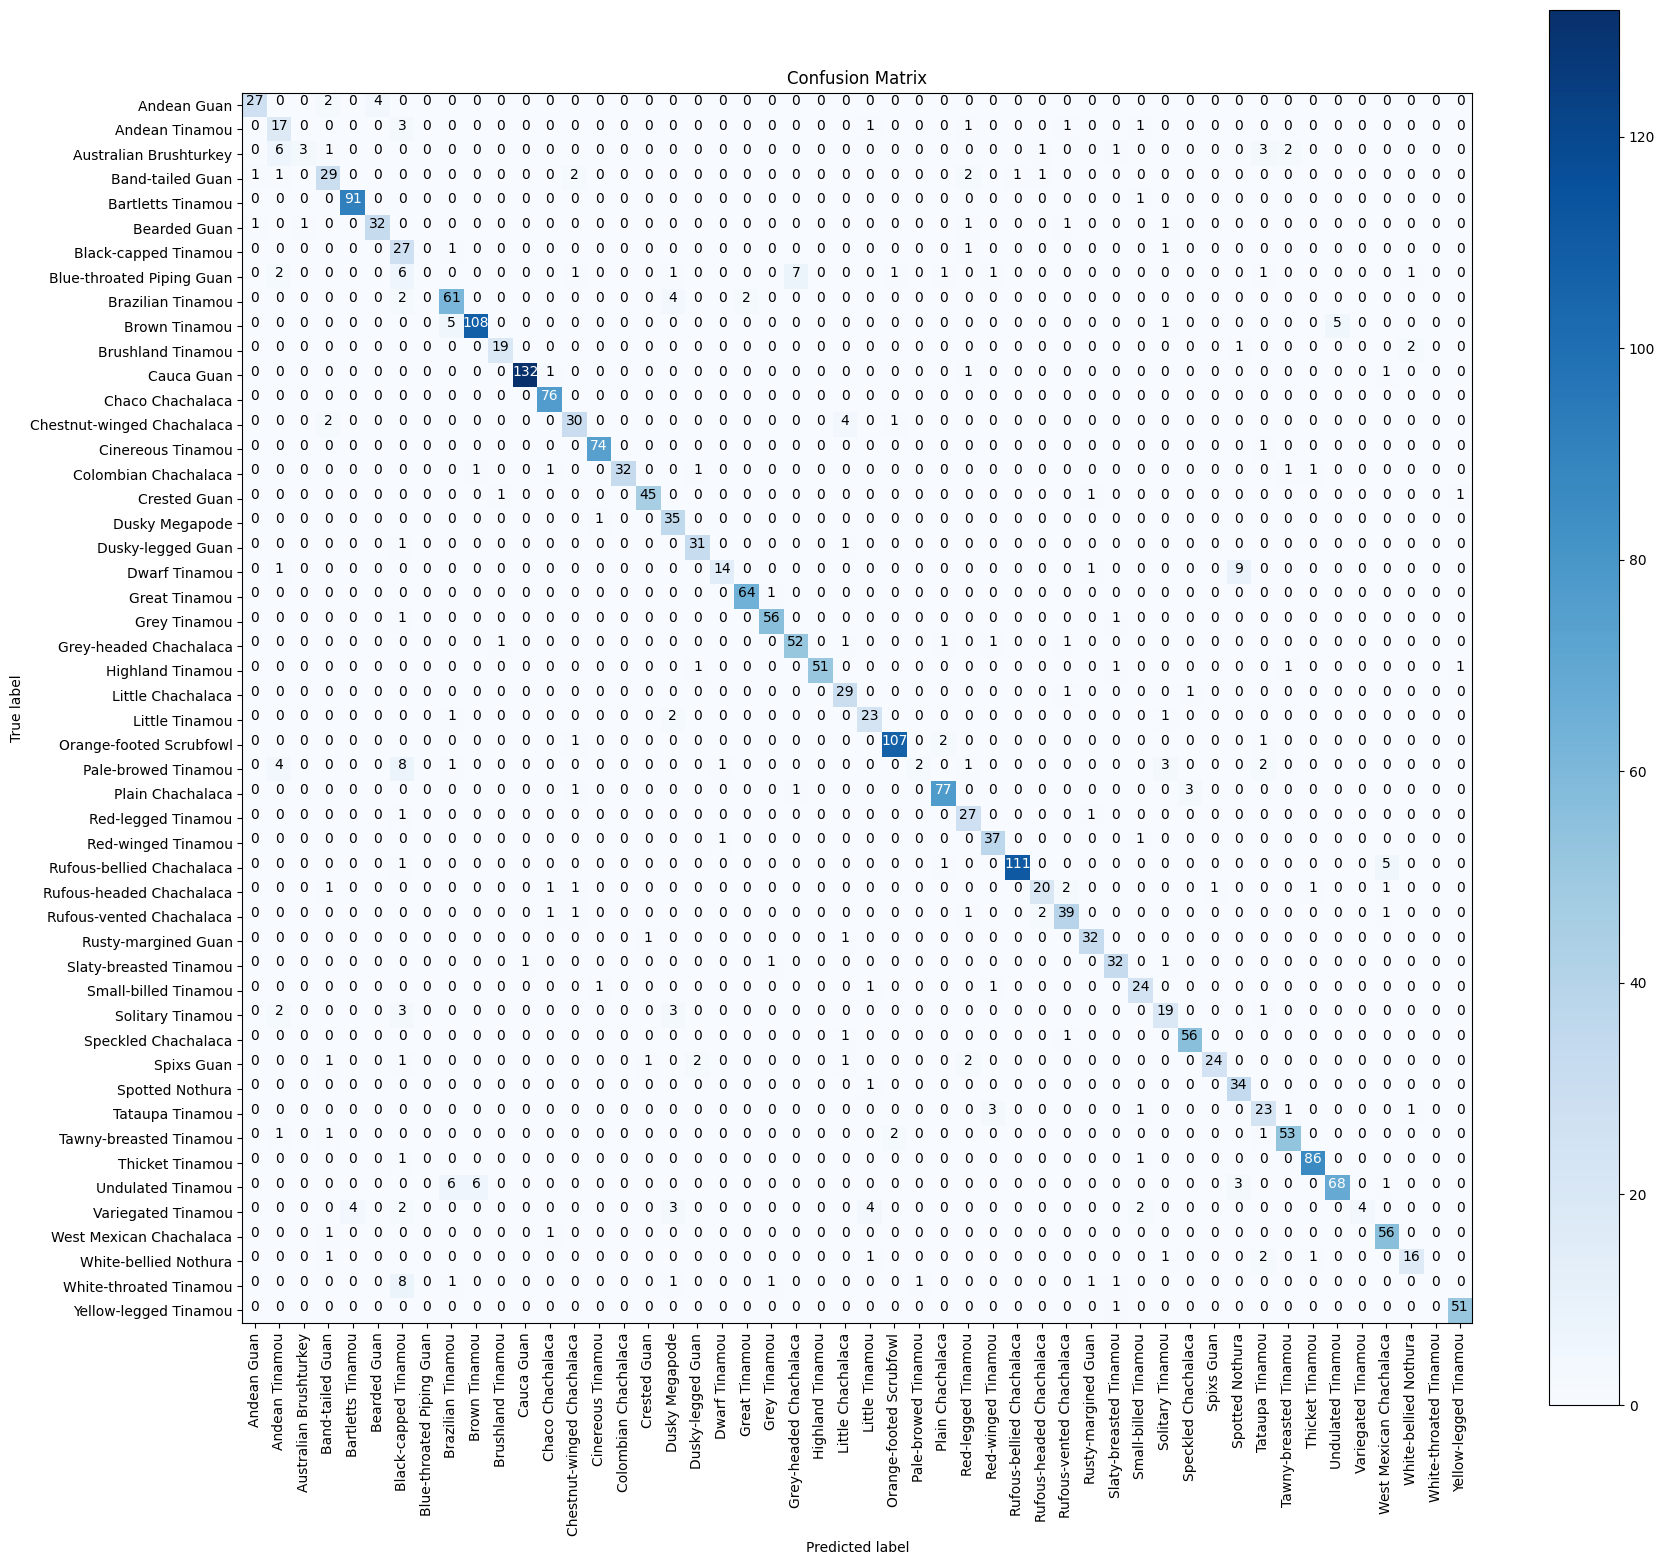


Classification report:

                            precision    recall  f1-score   support

               Andean Guan     0.9310    0.8182    0.8710        33
            Andean Tinamou     0.5000    0.7083    0.5862        24
    Australian Brushturkey     0.7500    0.1765    0.2857        17
          Band-tailed Guan     0.7436    0.7838    0.7632        37
         Bartletts Tinamou     0.9579    0.9891    0.9733        92
              Bearded Guan     0.8889    0.8649    0.8767        37
      Black-capped Tinamou     0.4154    0.9000    0.5684        30
 Blue-throated Piping Guan     0.0000    0.0000    0.0000        22
         Brazilian Tinamou     0.8026    0.8841    0.8414        69
             Brown Tinamou     0.9391    0.9076    0.9231       119
         Brushland Tinamou     0.9048    0.8636    0.8837        22
                Cauca Guan     0.9925    0.9778    0.9851       135
          Chaco Chachalaca     0.9383    1.0000    0.9682        76
Chestnut-winged Chacha

In [27]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(labels_list) <= 120:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred) # normalize='true'

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(18, 16), is_norm=False)

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [28]:
# Saving the trained model to a file for future use.
trainer.save_model()

In [29]:
# Specify the device on which you want to run the pipeline (e.g., GPU with device=0)
device = 0  # Change to the appropriate device index if needed

# Create a pipeline for audio classification with the specified model and device
pipe = pipeline('audio-classification', model=model_name, device=device)

In [30]:
# Load the audio file of the Andean Guan bird
audio, rate = torchaudio.load('/kaggle/input/sound-of-114-species-of-birds-till-2022/Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan11.mp3')

# Define a resampling transformation to match a specific sample rate (RATE_HZ)
transform = torchaudio.transforms.Resample(rate, RATE_HZ)

# Apply the resampling transformation to the audio
audio = transform(audio).numpy().reshape(-1)

# Create a classification pipeline and analyze the audio to identify the top 10 bird species
# This assumes 'pipe' is a function or method that performs the classification.
# If you have the 'pipe' function defined elsewhere, you should ensure it's correctly implemented.
# You might also want to provide more information about 'pipe' for better context.
pipe(audio, top_k=10)

[{'score': 0.8358902335166931, 'label': 'Andean Guan'},
 {'score': 0.10476481169462204, 'label': 'Bearded Guan'},
 {'score': 0.013527261093258858, 'label': 'Dusky-legged Guan'},
 {'score': 0.007986822165548801, 'label': 'Slaty-breasted Tinamou'},
 {'score': 0.007985949516296387, 'label': 'Dusky Megapode'},
 {'score': 0.004189609084278345, 'label': 'Little Tinamou'},
 {'score': 0.003692014142870903, 'label': 'Solitary Tinamou'},
 {'score': 0.0027390026953071356, 'label': 'Crested Guan'},
 {'score': 0.0025929389521479607, 'label': 'Variegated Tinamou'},
 {'score': 0.0024508561473339796, 'label': 'Red-legged Tinamou'}]

In [31]:
# Finally, show the audio
Audio(audio,rate=RATE_HZ)

# Send model to Huggingface

In [32]:
# Import the necessary module to interact with the Hugging Face Hub.
from huggingface_hub import notebook_login

# Perform a login to the Hugging Face Hub.
notebook_login()

In [33]:
# Import the HfApi class from the huggingface_hub library.
from huggingface_hub import HfApi

# Create an instance of the HfApi class.
api = HfApi()

# Define the repository ID by combining the username "dima806" with the model name.
repo_id = f"dima806/{model_name}"

try:
    # Attempt to create a new repository on the Hugging Face Model Hub using the specified repo_id.
    api.create_repo(repo_id)
    
    # If the repository creation is successful, print a message indicating that the repository was created.
    print(f"Repo {repo_id} created")
except:
    # If an exception is raised, print a message indicating that the repository already exists.
    print(f"Repo {repo_id} already exists")

Repo dima806/bird_sounds_classification already exists


In [34]:
# Uploading a folder to the Hugging Face Model Hub
api.upload_folder(
    folder_path=model_name,  # The path to the folder to be uploaded
    path_in_repo=".",  # The path where the folder will be stored in the repository
    repo_id=repo_id,  # The ID of the repository where the folder will be uploaded
    repo_type="model",  # The type of the repository (in this case, a model repository)
    revision="main" # Revision name
)

rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/623 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Upload 7 LFS files:   0%|          | 0/7 [00:00<?, ?it/s]

optimizer.pt:   0%|          | 0.00/757M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/3.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/3.57k [00:00<?, ?B/s]

'https://huggingface.co/dima806/bird_sounds_classification/tree/main/.'